In [5]:
import napari
from pathlib import Path
import numpy as np
import skimage
from napari_morphodynamics.napari_gui import MorphoWidget
from napari.utils import nbscreenshot
from IPython.display import Image

In [2]:
viewer = napari.Viewer()
widget = MorphoWidget(viewer)
viewer.window.add_dock_widget(widget)

# napari-morphodynamics
This napari plugin is composed of user-friendly tabs that can be run from left to right in order to complete a new analysis. The tabs guide the user through the necessary steps to perform data import, cell segmentation & windowing and later to display the intensity measurement results for the single windows, or as complex visualizations in the plots tab.

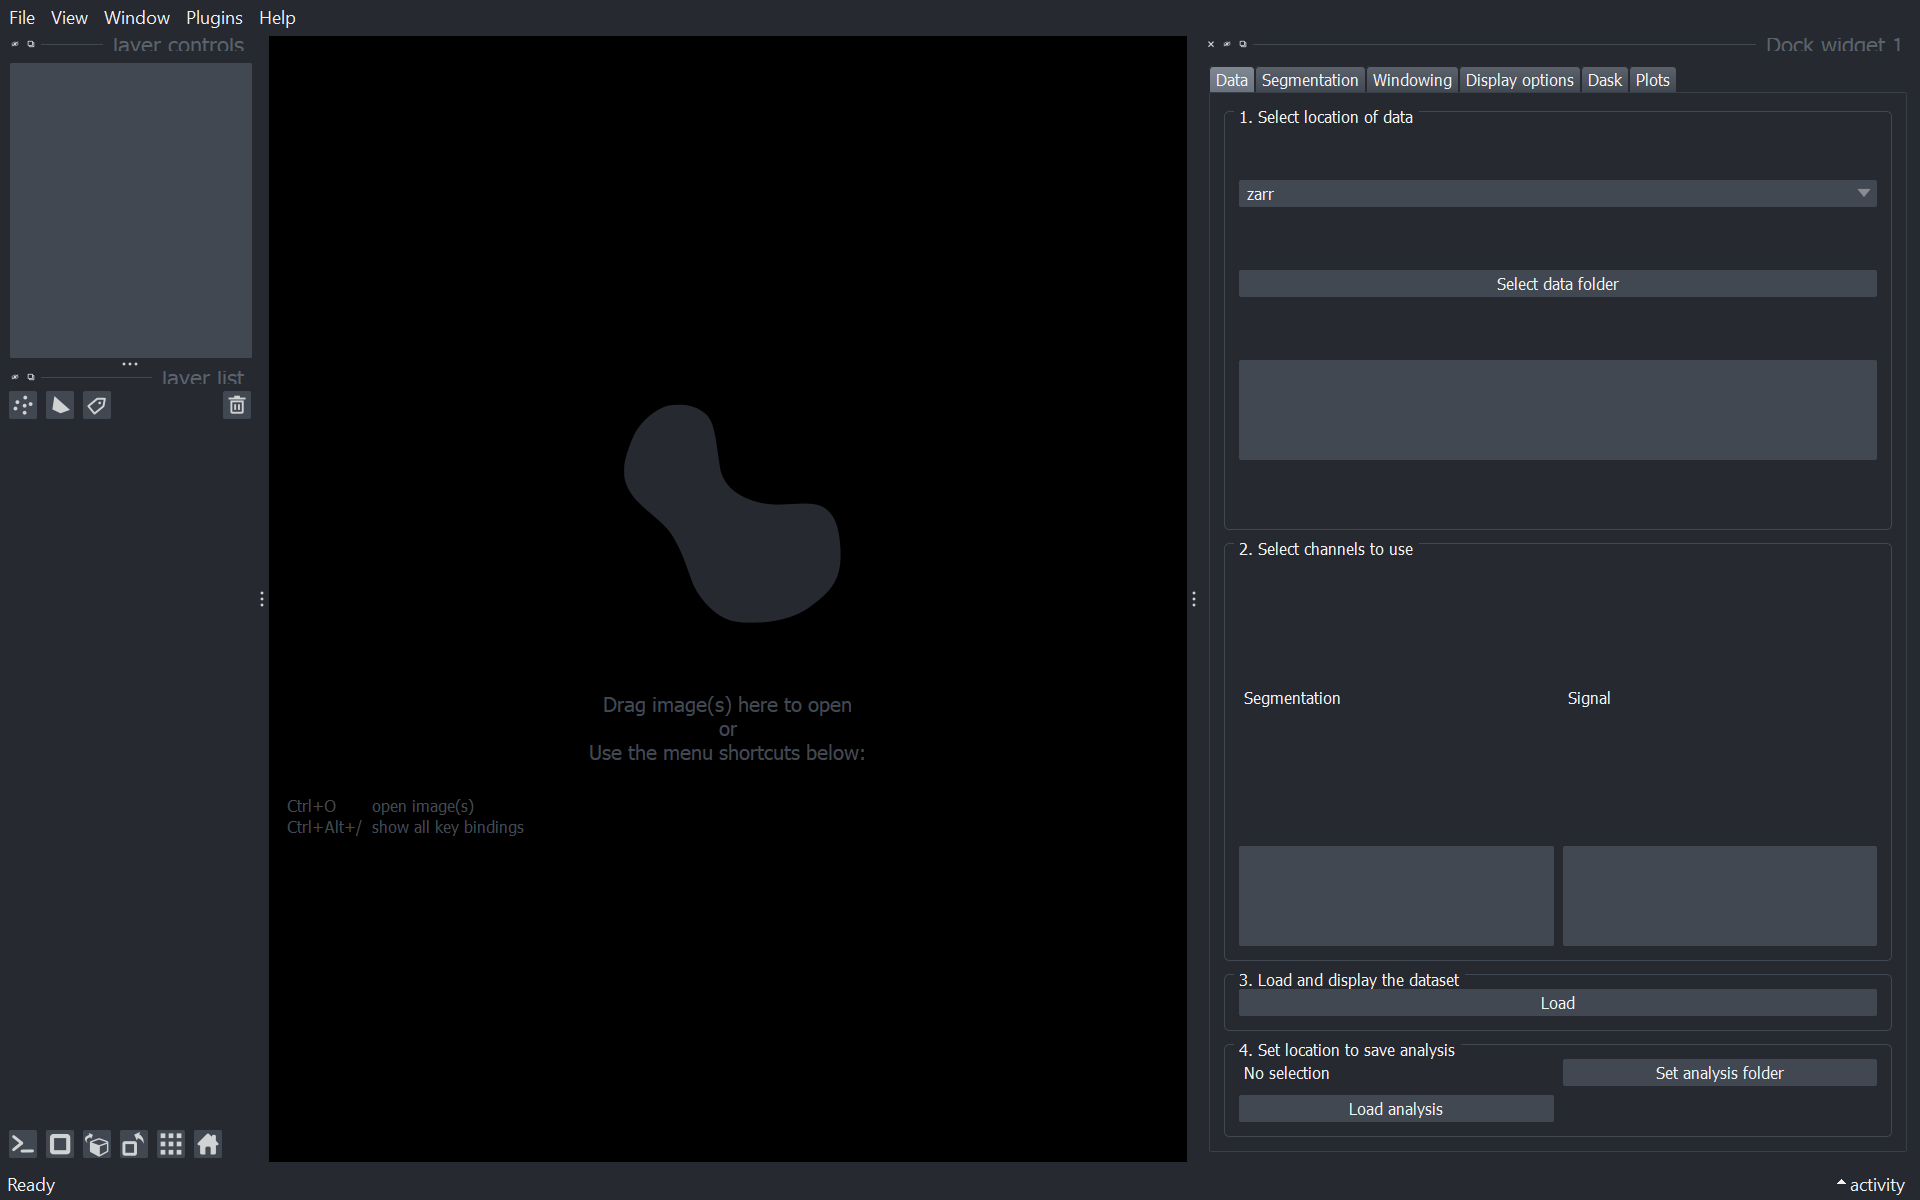

In [3]:
nbscreenshot(viewer)

# Data

## 1. Select location of data
napari-morphodynamics accepts different file formats as input data. In order to import the data correctly, you need to specify the file format that you wish to analyze.<br>
For a better insight into the file structure, please read the dedicated document in the [morphodynamics python package documentation](https://guiwitz.github.io/MorphoDynamics/mydocs/Data.html#)
Currently the supported file formats are:
- zarr
- [multipage tiff](https://guiwitz.github.io/MorphoDynamics/mydocs/Data.html#tif-stacks)
- [tiff series](https://guiwitz.github.io/MorphoDynamics/mydocs/Data.html#tif-sequences)
- nd2
- h5
- nparray

After selecting a folder containing the file format you have specified, a list of the folder content will be displayed.<br>
From this list select the file you wish to analyze and if the import worked correctly, the different channels composing the image should be displayed in the next menu.

## 2. Select channels to use
Different fluorescence signals can be analyzed simultaneously, therefore first select a single channel to be used for "Segmentation". Multiple selection is not possible for this menu.<br>
Then you can select multiple channels from the "Signal" list from which you wish to assess fluorescence intensities.

## 3. Load and display the dataset
So far you have only selected the file and image channels that you wish to import, but nothing has been imported in napari. Only after pressing the "Load" button the data will be imported and they should appear as napari image layers in the napari layer list.

## 4. Set location to save analysis
In this menu you have to specify the folder where the outputs of the analysis will be stored. This folder will be used in the segmentation section to store the segmented images but also downstream in the analysis to save all the results as python Results.pkl file, the parameters that were used for the analysis as .yaml file and to export some intensity measures as "Signals.csv" file.<br>
If you have already done an analysis and wish only to visualize the results here is where you could also specify a folder as described above from which you wish to load the data.



# Segmentation
As the cell segmentation is a fundamental step for windowing and downstream intensity quantification, we have dedicated particular attention to this process and implemented it with great flexibility. With the dropdown menu you can select between different state-of-the-art algorithms, including cellpose, and the in-house built deep-learning based pixel classifier called **conv-paint**.
Please, find more details about the [conv-paint tool](https://github.com/guiwitz/napari-convpaint) on the dedicated website.

## Cellpose
Cellpose is a generalist deep-learning based algorithm for the segmentation of cells and nuclei. napari-morphodynamics implements only the base model. However, the cellpose model can be retrained to fine tune it to the specific sample. For more information refer to the [cellpose github page](https://github.com/MouseLand/cellpose). If you have retrained a model and want to use the output of that segmentation, napari-morphodynamics offers the possibility to import this segmentation, as long as it is saved correctly. Please refer to the ["precomputed" section](#precomputed).

## Ilastik


## Farid

## Conv-paint
Conv-paint is a pixel classifier that relies on the first layers of a convolutional neural network (CNN) to extract features and then applies a random forest classification to predict the pixel class. Therefore, this process needs few image annotations. 

1. First select the image containing the signal used for segmentation. The default image is what you have selected as "Segmentation" when loading the data.
2. You then need a napari labels layer to be able to annotate the image. By clicking on the "Add annotation/predict layers" you will automatically create a labels layer for the "annotations", and the "prediction" layer that the algorithm will use to display the prediction of the pixel class, once the model is trained.
3. Make sure to select the "annotations" layer before starting to annotate the images. After selecting the layer use the "brush" icon to activate the annotation and start adding some labels for the background as label 1 and the cell signal as label 2.

```{warning}
Try to annotate about the same amount of pixels for the two different classes (background vs. foreground).
```
In general fewer annotations give a better result, so try to annotate as few pixel as possible, but still trying to select them to be representative for the different pixels that compose the background and the cell to segment.<br>
You can also modify the size of the brush in the napari layer control menu.

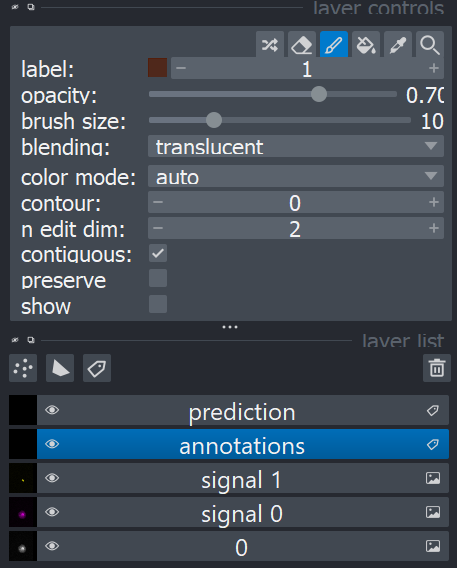

In [8]:
Image('images/annotations_layer.png')

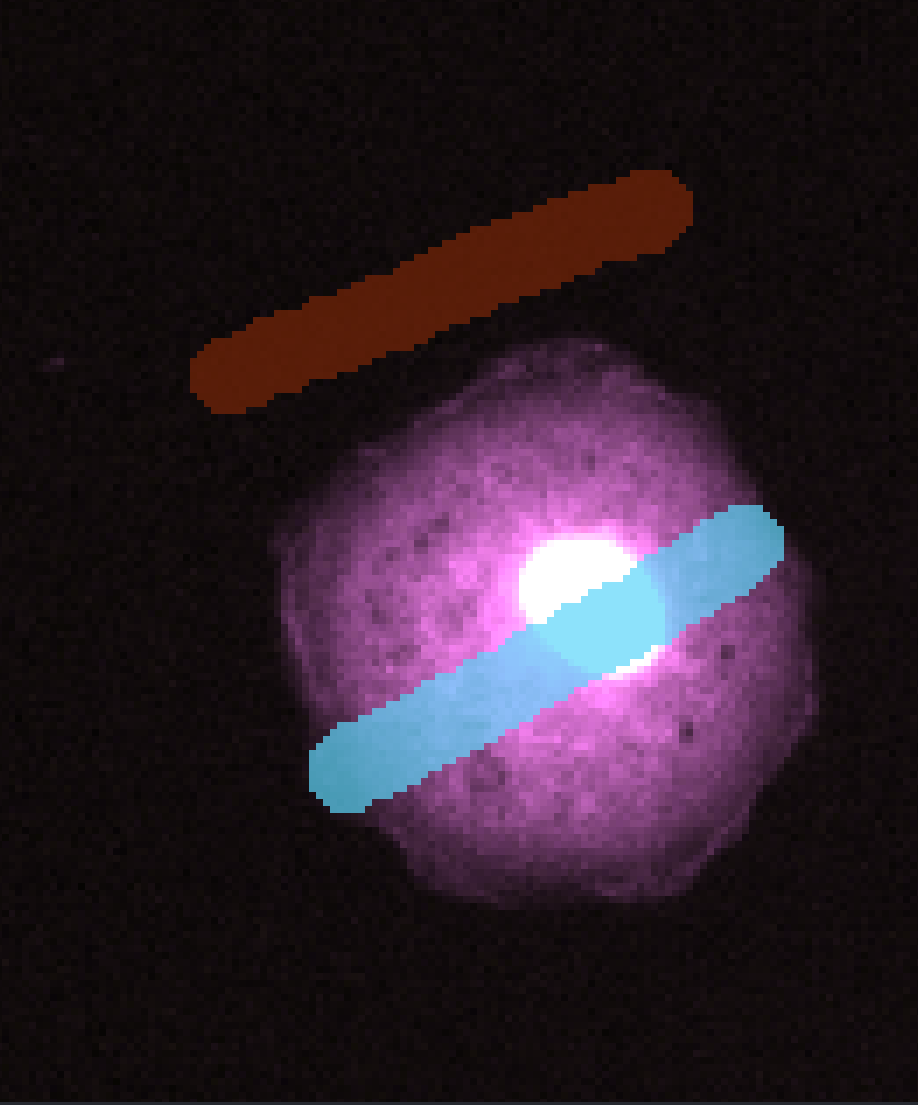

In [12]:
Image('images/annotation_suggestion.png')


4. After adding the annotations you need to train the model on the pixel that you have annotated. To do so press "Train model on single image".
5. When the training is completed you can display the prediction of a single frame using "Predict single frame" or on the entire dataset using the "Predict all frames button". The prediction of each pixel will appear in the "prediction" layer. This layer doesn't represent yet the segmentation of the images. It is only a probability map that displays if the pixel was classified as label 1 (background) or label 2 (foreground/cell).
Be aware that predicting all frames is computational heavy and will require some time. We therefore suggest to go through the dataset and predict only few time points to evaluate the performance of the model. <br> 
If you think that the performance is good you can go ahead and press the "Run segmentation" button. <br>
Otherwise you can take the time to add some more annotations. In this case it might be useful to predict all frames to find out where the algorithm struggles. After identifying a critical time point you could try to add more annotation in this specific time point. All the annotations are taken in consideration to retrain the model, even if they are on different time points. However, sometimes adding to many annotations confuses the algorithm even more. For this reason, in some case it is better to start from scratch, deleting all the annotations and adding new ones, for example focusing on time points that were difficult to predict.<br>

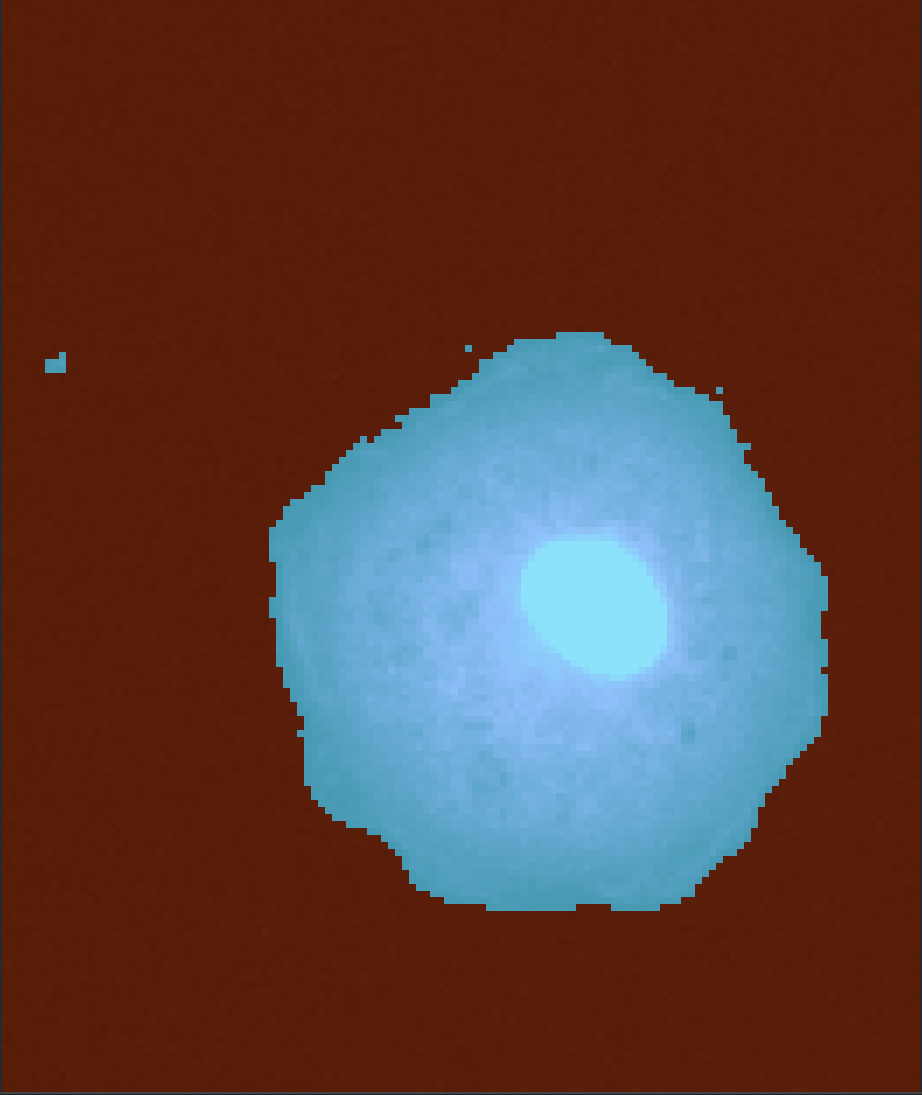

In [14]:
Image('images/prediction.png')

As in the example above, don't worry if there are some small objects that are erroneously predicted as foreground. At this point the pixels are still only predicted and in the segmentation process the algorithm will identify the main object as cell and track it over the different time points, this will result in ignoring such small object that doesn't belong to the main cell.

```{warning}
Only when pressing the "Run segmentation" button, the plugin will store the segmented images in the "analysis folder" that you have selected in the first tab. Once this process is completed you will be able to view the segmentation in the new napari layer called "Segmentation". In contrast, if you run "predict all frames", this segmentation will not be saved, and therefore the analysis can not proceed to the subsequent steps.
```

## precomputed
To improve the flexibility of the napari-morphodynamics plugin this menu allows the import of already segmented data. For the segmentation the user can opt for any other tool or software and import the data here by pointing to a folder containing the segmentation.<br>
Currently napari-morphodynamics can only import the segmentation if the file names are as follow:
- segmented_k_0.tif
- segmented_k_1.tif
- etc...
Where k refers to the time point of the time lapse. Please rename the file accordingly, considering that "segmented" is not an example, but a requirement!

# Windowing
